In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Caminho para o arquivo local
caminho_arquivo = 'data/adult/adult.data'

# Nomes das colunas conforme documentação da UCI
colunas = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race", "sex",
    "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
]

# Leitura do arquivo
df = pd.read_csv(caminho_arquivo, names=colunas, na_values=" ?", skipinitialspace=True)

# Visualizar primeiras linhas
print(df.head())


   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

In [2]:
# Verificar valores nulos
print(df.isnull().sum())

# Número total de linhas
total_linhas = len(df)

# Número de linhas com ao menos um valor nulo
linhas_com_nulos = df.isnull().any(axis=1).sum()

# Porcentagem
porcentagem_nulos = (linhas_com_nulos / total_linhas) * 100

print(f"{porcentagem_nulos:.2f}% das linhas possuem ao menos um valor nulo.")

# Remover linhas com valores faltantes
df.dropna(inplace=True)

# Remover colunas pouco informativas
df.drop(['fnlwgt'], axis=1, inplace=True)

# Transformar variáveis categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Normalizar os dados
scaler = StandardScaler()
X = df.drop('income', axis=1)
y = df['income']

X_scaled = scaler.fit_transform(X)

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
0.00% das linhas possuem ao menos um valor nulo.


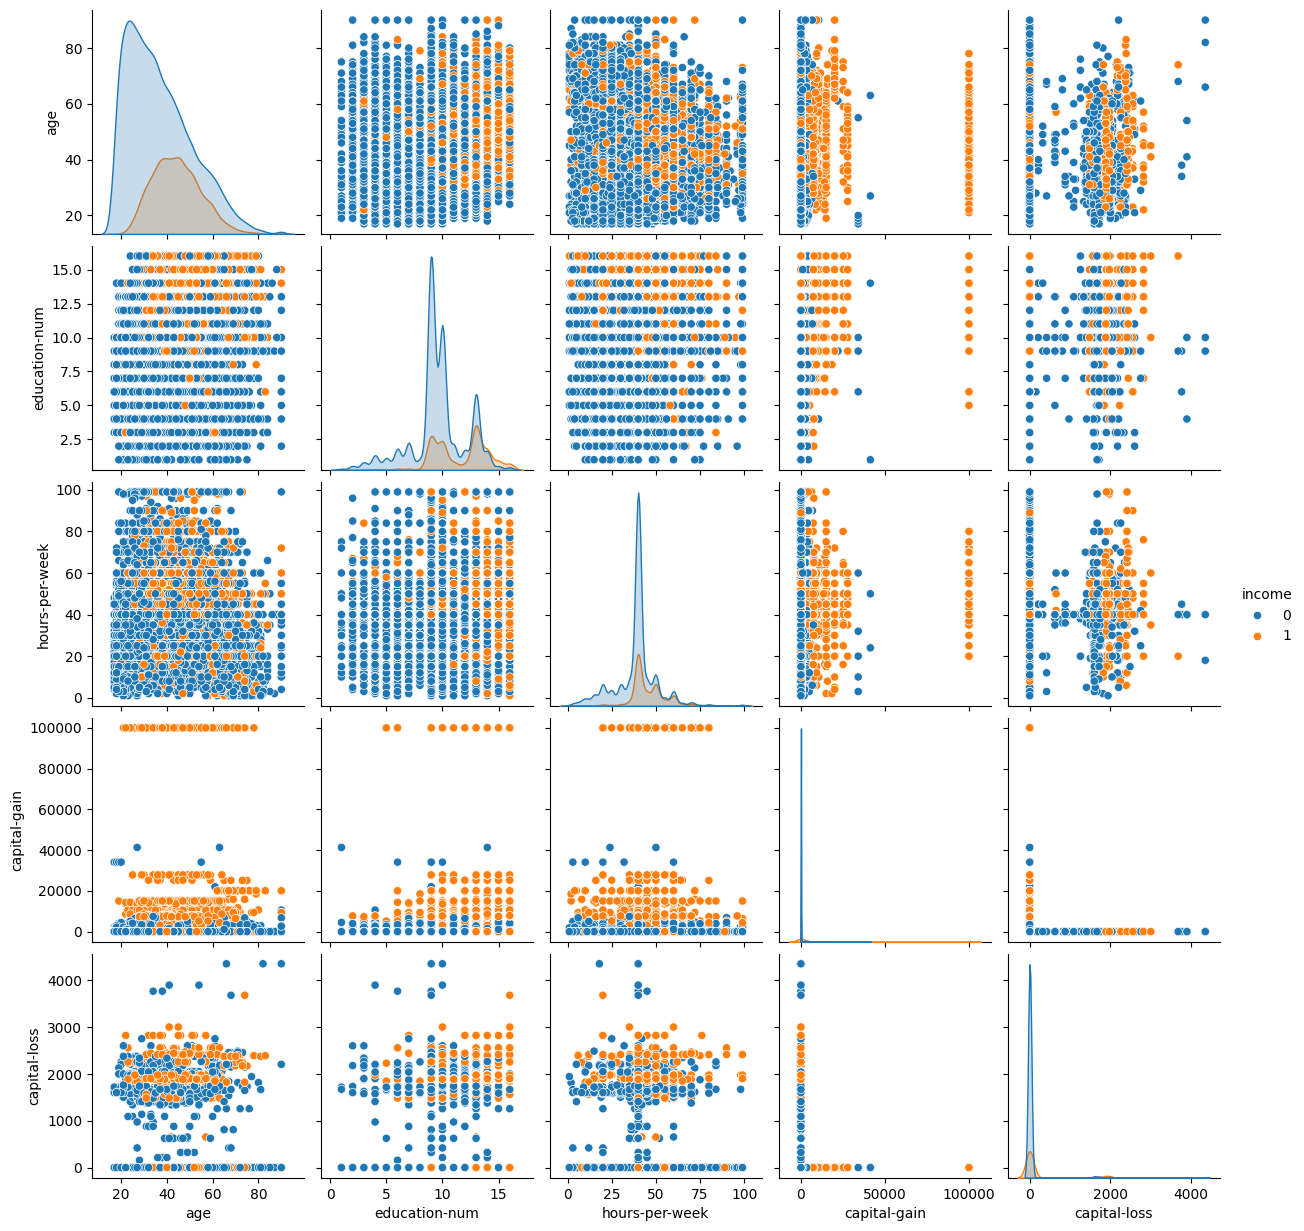

In [3]:
# Selecionar apenas algumas colunas para visualização
subset = df[['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss', 'income']]
sns.pairplot(subset, hue='income', diag_kind='kde')
plt.show()

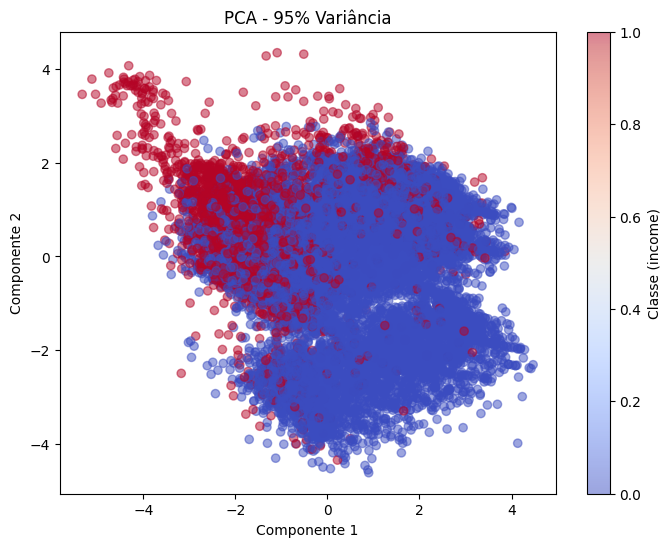

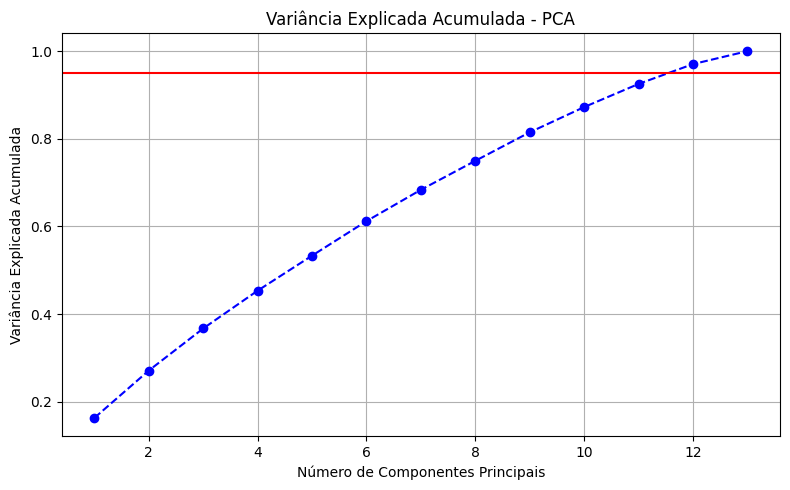

In [4]:

# Inicializar o PCA para manter 95% da variância
pca = PCA(n_components=0.95)

# Ajustar e transformar os dados
X_pca = pca.fit_transform(X_scaled)

# Visualização com PCA
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.title("PCA - 95% Variância")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.colorbar(label="Classe (income)")
plt.show()

# Ajustar a PCA novamente apenas para visualizar a variância de cada componente
pca_full = PCA()
pca_full.fit(X_scaled)

# Variância explicada acumulada
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

# Plotar
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cum_var) + 1), cum_var, marker='o', linestyle='--', color='b')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.title("Variância Explicada Acumulada - PCA")
plt.xlabel("Número de Componentes Principais")
plt.ylabel("Variância Explicada Acumulada")
plt.grid(True)
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Melhores parâmetros encontrados: {'activation': 'tanh', 'hidden_layer_sizes': (30,), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}
Acurácia média (cross-validação): 0.8505
Acurácia no teste (20%): 0.8521

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      4942
           1       0.74      0.60      0.66      1571

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.78      6513
weighted avg       0.85      0.85      0.85      6513



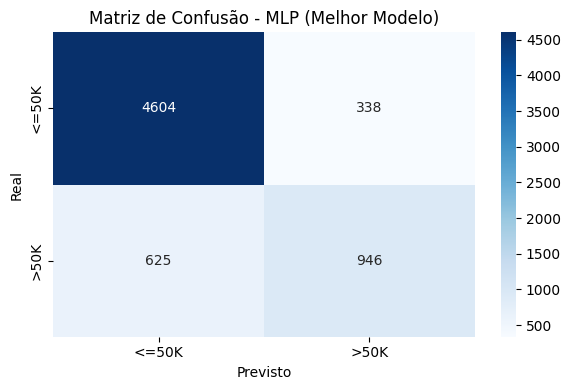

In [6]:
# Dividir dados em treino (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Definir o classificador base
mlp = MLPClassifier(random_state=42)

# Grid de parâmetros: tamanhos e número de camadas ocultas
param_grid = {
    'max_iter': [500, 750, 1000],
    'hidden_layer_sizes': [
        (30,), (60,), (100,),              # 1 camada
        (30, 30), (60, 60), (100, 100),     # 2 camadas
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

# GridSearchCV com validação cruzada
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_
print("Melhores parâmetros encontrados:", grid_search.best_params_)
print(f"Acurácia média (cross-validação): {grid_search.best_score_:.4f}")

# Avaliação no conjunto de teste
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Acurácia no teste (20%): {test_accuracy:.4f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['income'].classes_,
            yticklabels=label_encoders['income'].classes_)
plt.title("Matriz de Confusão - MLP (Melhor Modelo)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

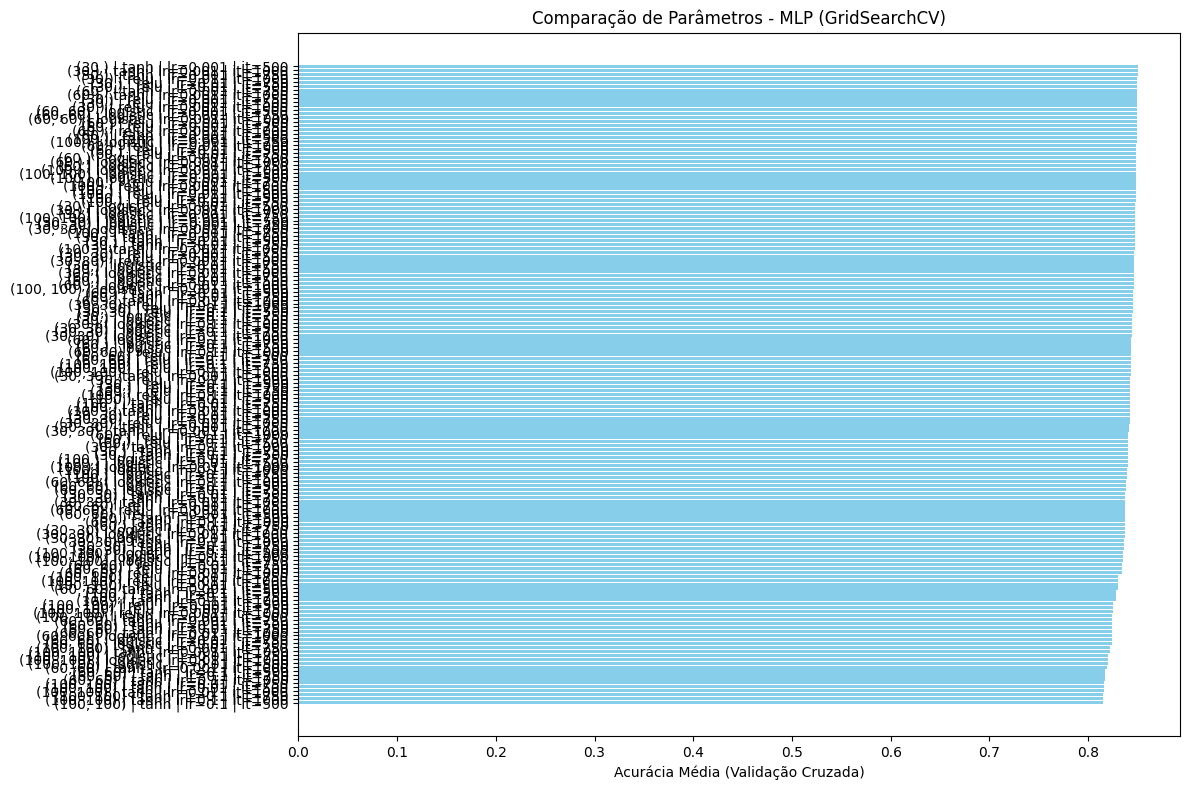

In [7]:
# Transformar os resultados do GridSearch em DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Criar coluna descritiva para as combinações de parâmetros
results['param_combo'] = results['param_hidden_layer_sizes'].astype(str) + " | " + \
                         results['param_activation'].astype(str) + " | lr=" + \
                         results['param_learning_rate_init'].astype(str) + " | it=" + \
                         results['param_max_iter'].astype(str)

# Ordenar pela acurácia média
results.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Plotar gráfico de barras com as melhores combinações
plt.figure(figsize=(12, 8))
plt.barh(results['param_combo'], results['mean_test_score'], color='skyblue')
plt.xlabel("Acurácia Média (Validação Cruzada)")
plt.title("Comparação de Parâmetros - MLP (GridSearchCV)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

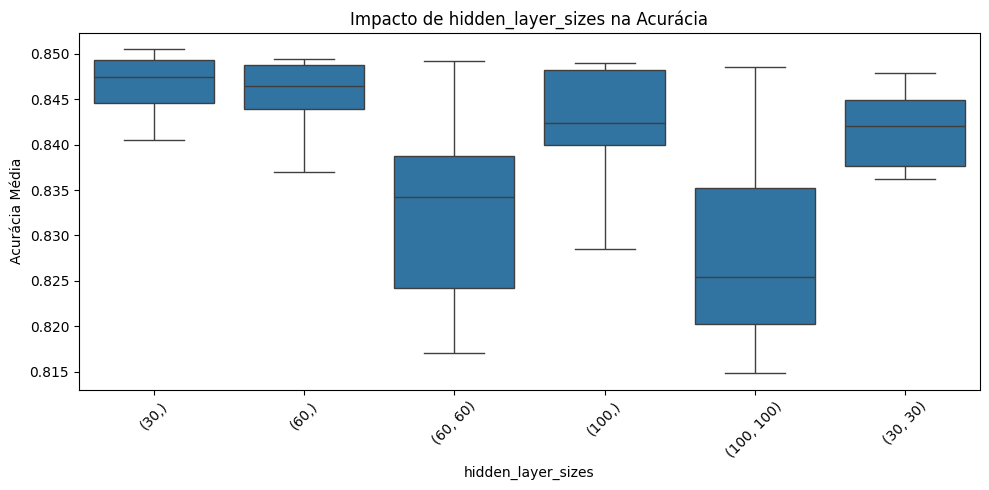

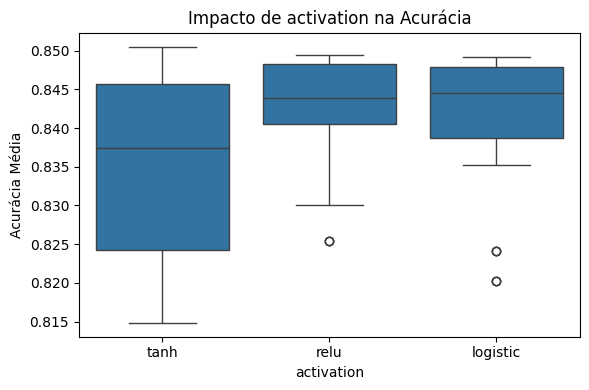

In [9]:
# Boxplot: hidden_layer_sizes
plt.figure(figsize=(10, 5))
# Converter as tuplas em strings para o boxplot
results['hidden_layer_sizes_str'] = results['param_hidden_layer_sizes'].astype(str)
sns.boxplot(data=results, x='hidden_layer_sizes_str', y='mean_test_score')
plt.title("Impacto de hidden_layer_sizes na Acurácia")
plt.xticks(rotation=45)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Acurácia Média")
plt.tight_layout()
plt.show()

# Boxplot: activation
plt.figure(figsize=(6, 4))
sns.boxplot(data=results, x='param_activation', y='mean_test_score')
plt.title("Impacto de activation na Acurácia")
plt.xlabel("activation")
plt.ylabel("Acurácia Média")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Melhores parâmetros encontrados para KNN: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
Acurácia média (cross-validação): 0.8384
Acurácia no teste (20%): 0.8442

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      4942
           1       0.71      0.60      0.65      1571

    accuracy                           0.84      6513
   macro avg       0.79      0.76      0.78      6513
weighted avg       0.84      0.84      0.84      6513



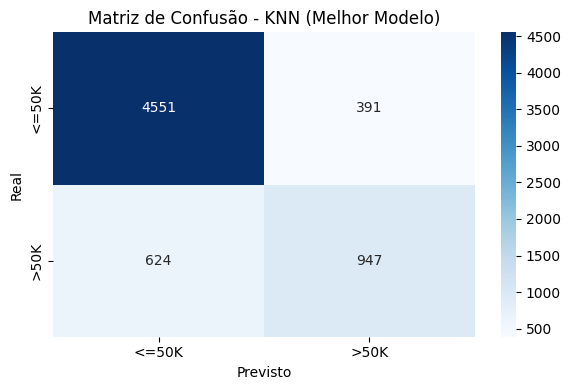

In [11]:
# Definir o classificador base
knn = KNeighborsClassifier()

# Grid de parâmetros para o KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV com validação cruzada
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search_knn.fit(X_train, y_train)

# Melhor modelo
best_model_knn = grid_search_knn.best_estimator_
print("\nMelhores parâmetros encontrados para KNN:", grid_search_knn.best_params_)
print(f"Acurácia média (cross-validação): {grid_search_knn.best_score_:.4f}")

# Avaliação no conjunto de teste
y_pred_knn = best_model_knn.predict(X_test)
test_accuracy_knn = accuracy_score(y_test, y_pred_knn)

print(f"Acurácia no teste (20%): {test_accuracy_knn:.4f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_knn))

# Matriz de Confusão
cm_knn = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['income'].classes_,
            yticklabels=label_encoders['income'].classes_)
plt.title("Matriz de Confusão - KNN (Melhor Modelo)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

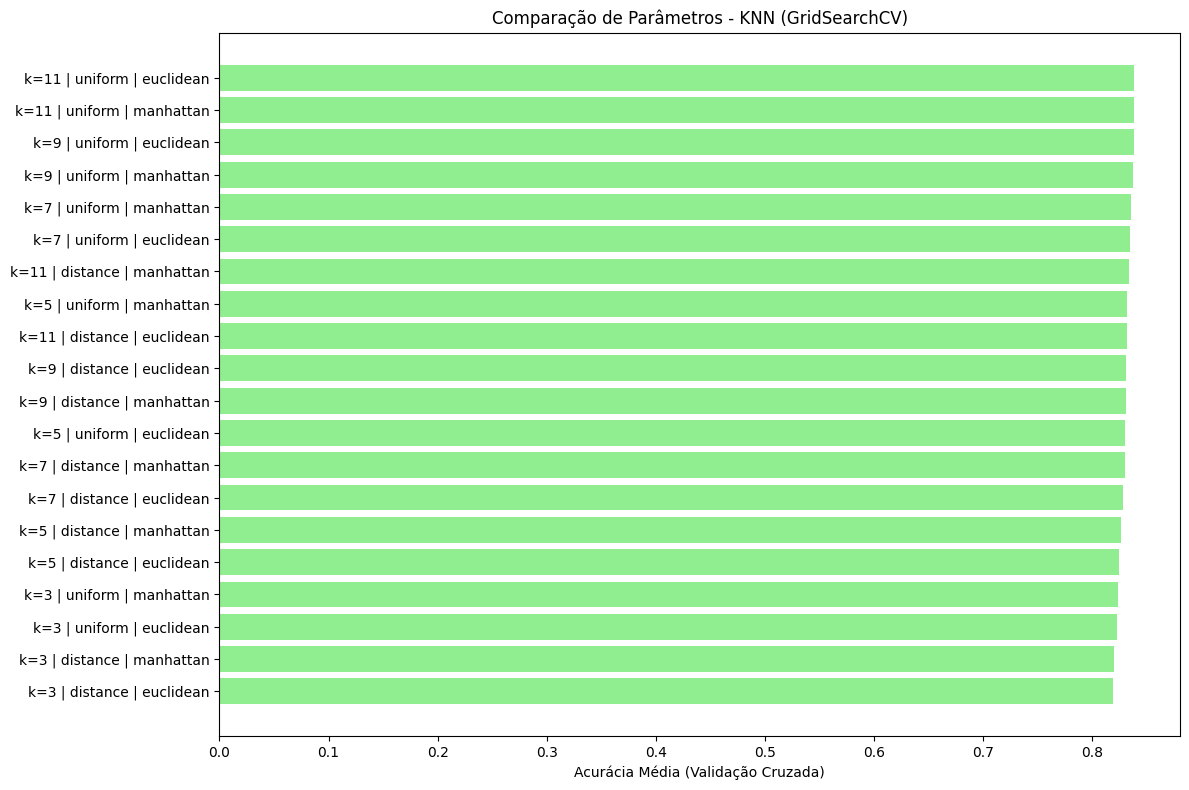

In [12]:
# Visualização dos resultados do GridSearch para KNN
results_knn = pd.DataFrame(grid_search_knn.cv_results_)

# Criar coluna descritiva para as combinações de parâmetros
results_knn['param_combo'] = "k=" + results_knn['param_n_neighbors'].astype(str) + " | " + \
                            results_knn['param_weights'] + " | " + \
                            results_knn['param_metric']

# Ordenar pela acurácia média
results_knn.sort_values(by='mean_test_score', ascending=False, inplace=True)

# Plotar gráfico de barras com as melhores combinações
plt.figure(figsize=(12, 8))
plt.barh(results_knn['param_combo'], results_knn['mean_test_score'], color='lightgreen')
plt.xlabel("Acurácia Média (Validação Cruzada)")
plt.title("Comparação de Parâmetros - KNN (GridSearchCV)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

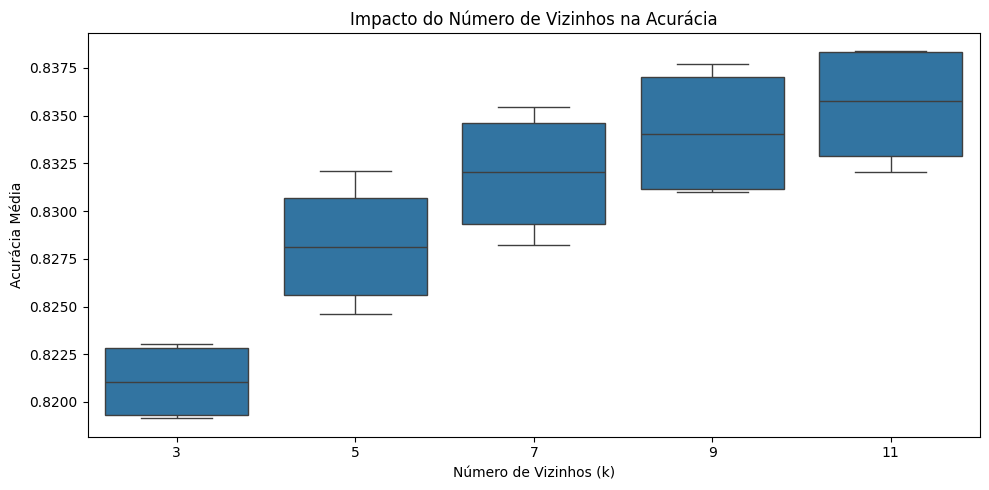

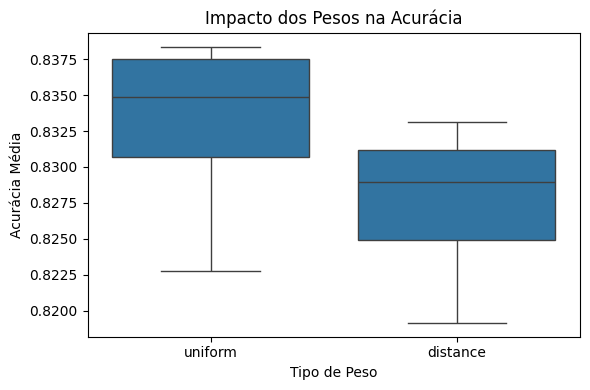

In [13]:
# Boxplot para número de vizinhos
plt.figure(figsize=(10, 5))
sns.boxplot(data=results_knn, x='param_n_neighbors', y='mean_test_score')
plt.title("Impacto do Número de Vizinhos na Acurácia")
plt.xlabel("Número de Vizinhos (k)")
plt.ylabel("Acurácia Média")
plt.tight_layout()
plt.show()

# Boxplot para pesos
plt.figure(figsize=(6, 4))
sns.boxplot(data=results_knn, x='param_weights', y='mean_test_score')
plt.title("Impacto dos Pesos na Acurácia")
plt.xlabel("Tipo de Peso")
plt.ylabel("Acurácia Média")
plt.tight_layout()
plt.show()